In [2]:
import av
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [4]:
# Укажите путь к папке
folder_path = 'video'

# Получаем список файлов в папке
files_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

video_path = os.path.abspath(os.path.join(folder_path, files_list[2]))
print(video_path)
container = av.open(video_path)
fps = container.streams.video[0].average_rate
fps = eval(str(fps))

C:\Users\Sergey\Documents\GitHub\secret-repo\video\Бекстейдж [TubeRipper.com].mp4


In [5]:
#Достаем из видео фиксированное количество кадров через равный промежуток
def const_even_division(container, num_frame):
    total_frames = container.streams.video[0].frames
    indices = np.arange(0, total_frames, total_frames / num_frame).astype(int)
    return indices
    
indices = const_even_division(container, 10)

ZeroDivisionError: float division by zero

In [6]:
print(indices)

NameError: name 'indices' is not defined

In [7]:
#scenedetect - очень интересная библиотека, можно попробовать поиграть с различными методами (см доку)
#Работает на основе цветовой гаммы 

from scenedetect import detect, AdaptiveDetector, split_video_ffmpeg, SceneDetector
from scenedetect import VideoManager, SceneManager
from scenedetect.detectors import ContentDetector

In [8]:
#baseline
scene_list = detect(video_path, AdaptiveDetector())
scene_list = [i[0].get_frames() for i in scene_list]
len(scene_list)

27

In [9]:
from scenedetect import VideoManager, SceneManager
from scenedetect.detectors import AdaptiveDetector, ContentDetector, HashDetector, HistogramDetector, ThresholdDetector
from scenedetect.scene_detector import SceneDetector

# Создаем VideoManager и SceneManager
video_manager = VideoManager([video_path])

# Подготавливаем несколько SceneManager для разных детекторов
scene_managers = [SceneManager() for _ in range(5)]

# Добавляем различные детекторы к каждому SceneManager
scene_managers[0].add_detector(ContentDetector(threshold=30.0))  # Обнаружение по содержимому
scene_managers[1].add_detector(ThresholdDetector(threshold=12))  # Обнаружение по порогу изменений
scene_managers[2].add_detector(HistogramDetector(min_scene_len=15))  # Обнаружение по гистограмме
scene_managers[3].add_detector(AdaptiveDetector(adaptive_threshold=3.0))  # Адаптивный детектор
scene_managers[4].add_detector(HashDetector())  # Гистограммный детектор

# Запускаем VideoManager
#video_manager.set_downscale_factor()  # Понижение качества для ускорения
video_manager.start()

# Массив для хранения списков сцен от разных детекторов
all_scene_lists = []

# Запускаем детекцию для каждого SceneManager и собираем результаты
for scene_manager in scene_managers:
    scene_manager.detect_scenes(frame_source=video_manager)
    scenes = scene_manager.get_scene_list()
    all_scene_lists.append(scenes)
    video_manager.reset()


VideoManager is deprecated and will be removed.


In [10]:
from collections import Counter

# Функция для объединения сцен с устранением дубликатов
def merge_scene_lists(scene_lists):
    fps_window = fps*1.3
    
    all_scene_list = []
    all_scene_list.append(scene_lists[0][0][0].get_frames())
    for scene_list in scene_lists:
        for scene in scene_list:
            all_scene_list.append(scene[1].get_frames())
    
    scene_counter = Counter(all_scene_list)
    scene_counter_key = sorted(scene_counter.keys())

    # Список для объединенных сцен
    combined_scenes = []

    # Проходим по отсортированным сценам и объединяем их при необходимости
    current_scene = scene_counter_key[0]  # Инициализируем первой сценой

    x = 0
    for next_scene in scene_counter_key[1:]:
        # Если разница между концом текущей сцены и началом следующей меньше порога, объединяем
        if next_scene - current_scene <= fps_window:
            if scene_counter[next_scene] > scene_counter[current_scene]:
                scene_counter[next_scene] += scene_counter[current_scene]/2
                del scene_counter[current_scene]
                current_scene = next_scene
            
            else:
                scene_counter[current_scene] += scene_counter[next_scene]/2
                del scene_counter[next_scene]
        else:
            current_scene = next_scene
                
    filtered_scene_counter = {k: v for k, v in scene_counter.items() if v > 2}
    
    return sorted(filtered_scene_counter.keys())

# Функция для вывода сцен
def print_scenes(scenes):
    for i, scene in enumerate(scenes):
        print(f"Scene {i + 1}: Start frame: {scene[0].get_frames()}, End frame: {scene[1].get_frames()}")


# Объединяем результаты всех детекторов с устранением дубликатов
merged_scenes = merge_scene_lists(all_scene_lists)


# Выводим объединенные сцены
#print_scenes(merged_scenes)
print(merged_scenes)
# Очищаем ресурсы
video_manager.release()

[0, 67, 138, 207, 269, 393, 474, 532, 589, 649, 712, 765, 824, 873, 941, 1009, 1059, 1110, 1178, 1249, 1311, 1370, 1422, 1485, 1540, 1595, 1652, 1700]


In [11]:
196

196

In [12]:
scene_list

[0,
 67,
 138,
 207,
 269,
 393,
 474,
 532,
 589,
 649,
 712,
 765,
 824,
 873,
 941,
 1009,
 1059,
 1110,
 1178,
 1249,
 1311,
 1370,
 1422,
 1485,
 1540,
 1595,
 1652]

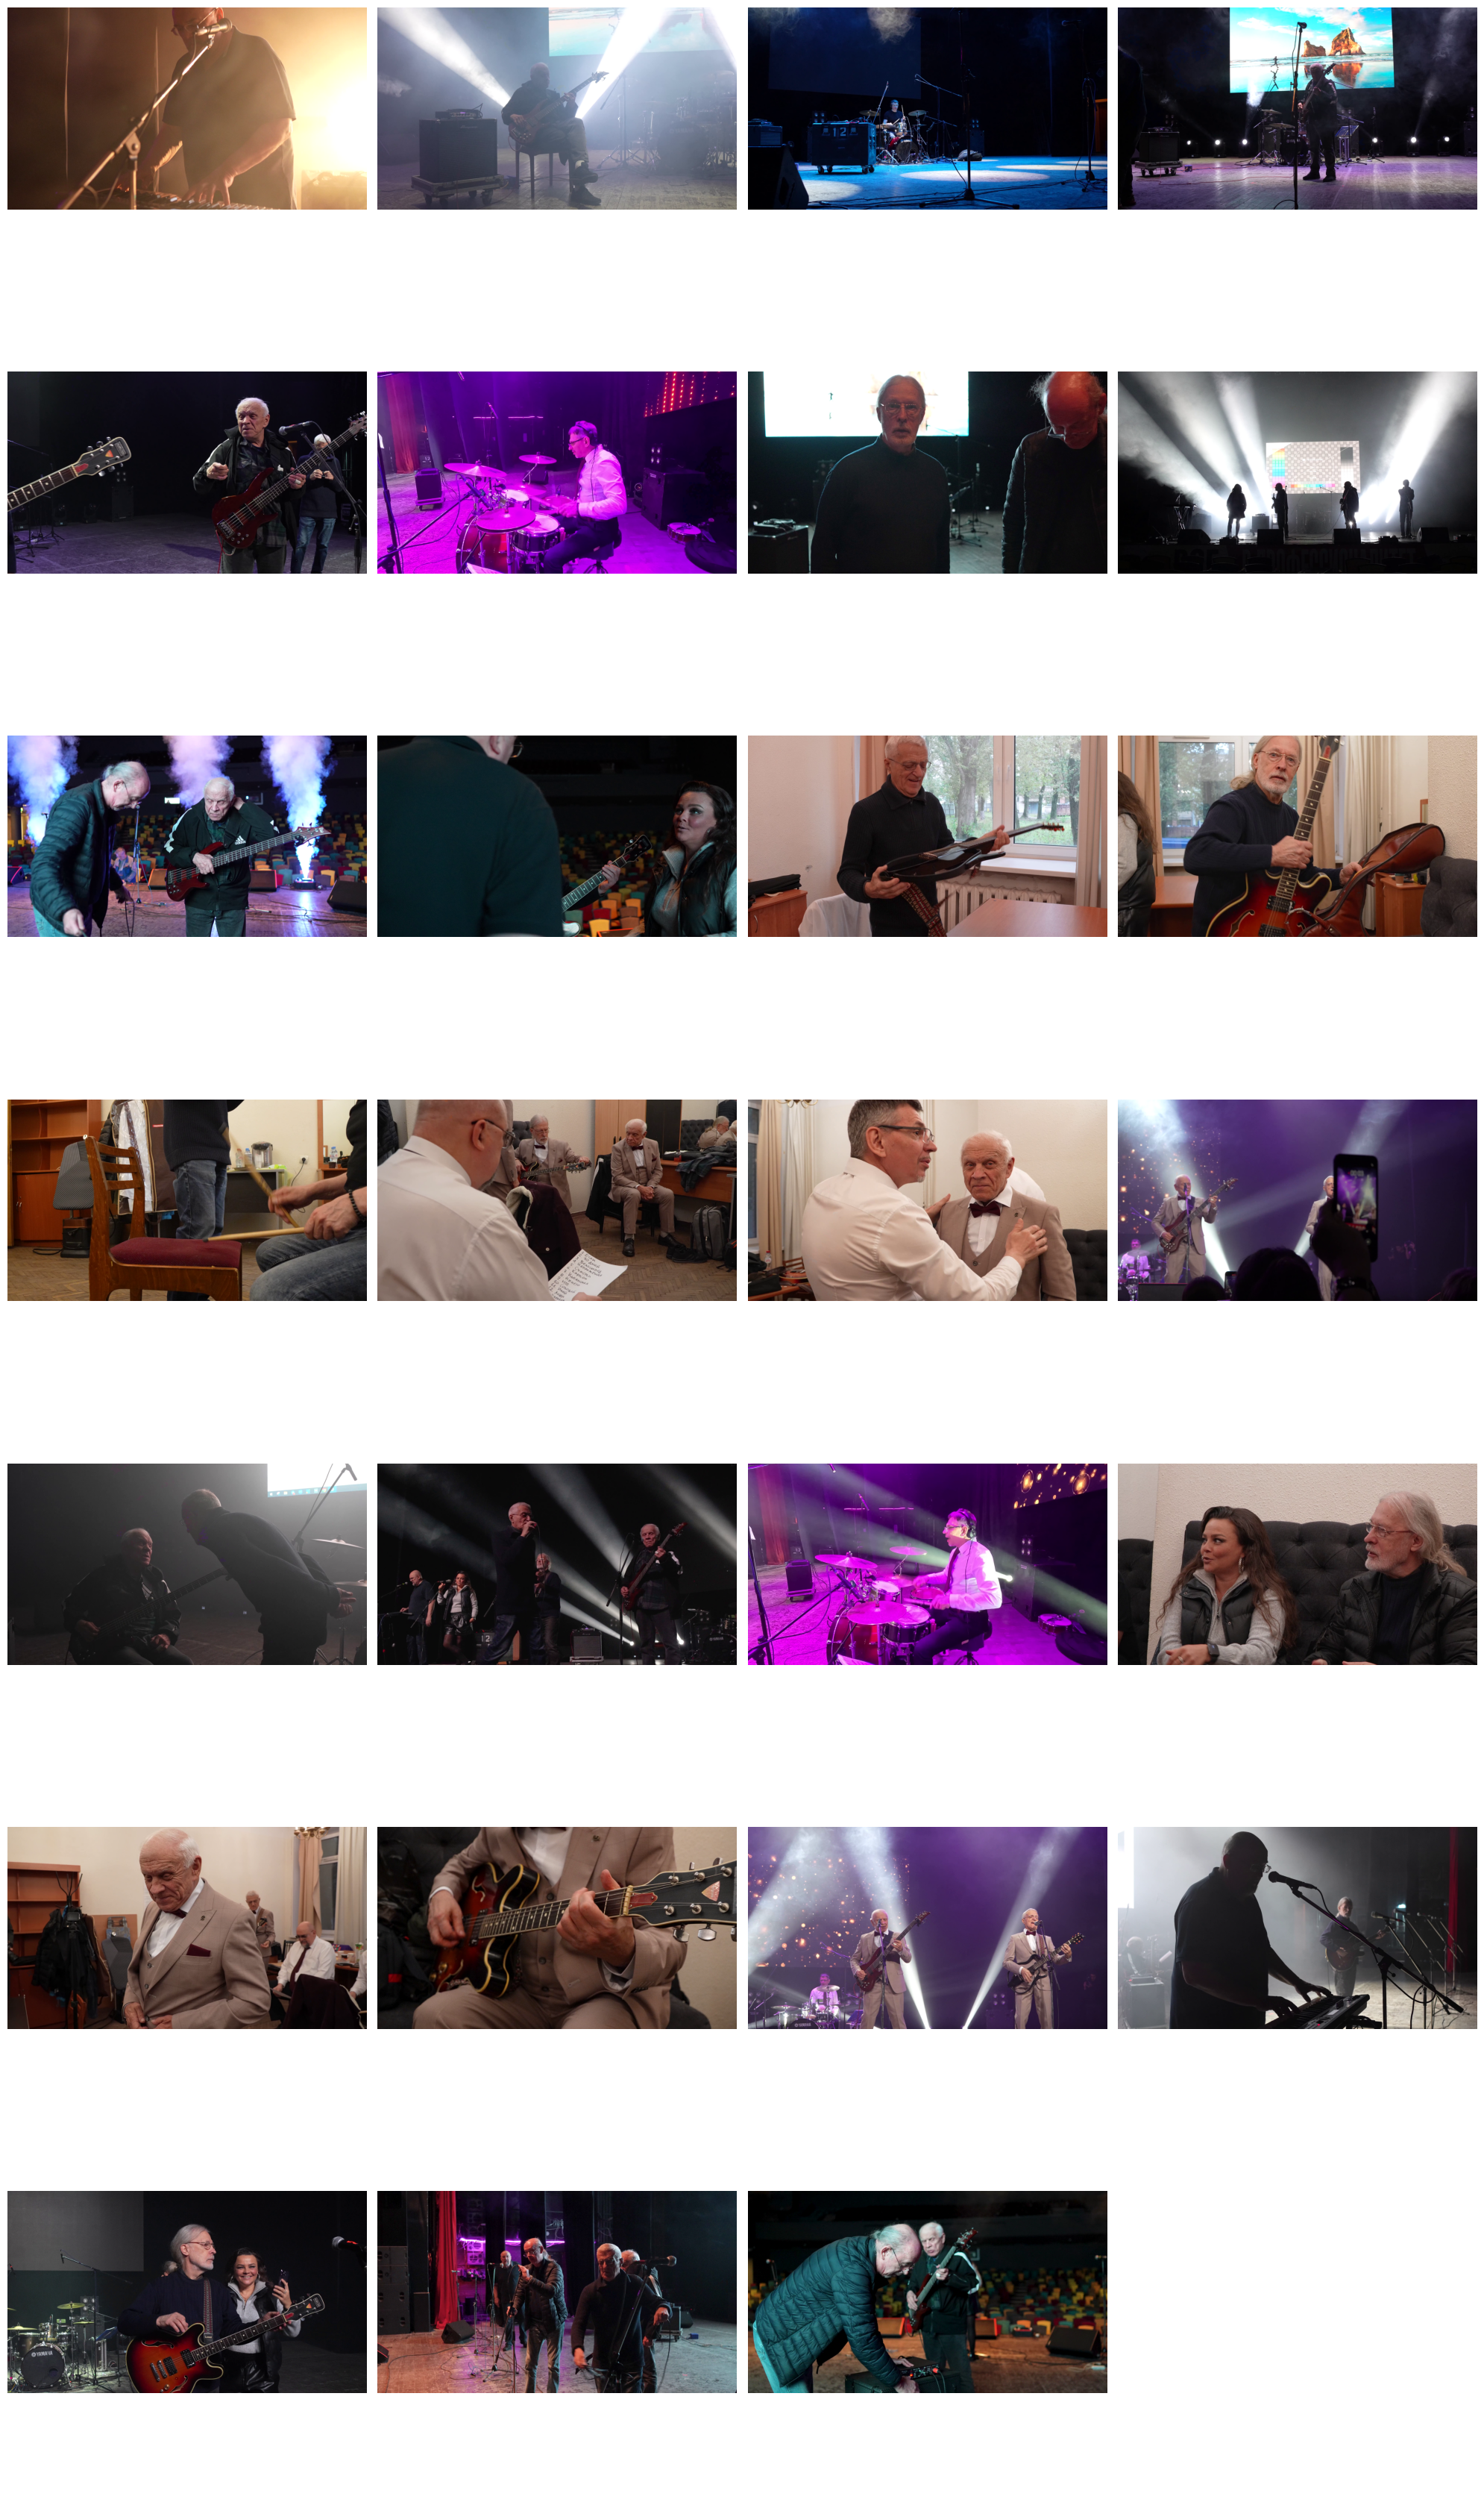

In [13]:
def show_frame(video_path, indices, cols=4, cell_size=(5, 5)):
    # Открываем видео в контекстном менеджере
    with av.open(video_path) as container:
        
        # Создаем пустой список для кадров
        frames = []
        
        # Извлечение кадров по индексам
        for i, frame in enumerate(container.decode(video=0)):
            if i in indices:
                frames.append(frame.to_image())  # Конвертируем в формат PIL

            if i > max(indices):  # Останавливаем, когда получили все нужные кадры
                break

    # Определение количества кадров для отображения
    num_frames = len(frames)
    
    # Определяем количество строк и колонок для субплотов
    rows = math.ceil(num_frames / cols)  # Рассчитываем количество строк
    
    # Рассчитываем динамический размер фигуры
    figsize = (cols * cell_size[0], rows * cell_size[1])
    
    # Визуализируем выбранные кадры с увеличенным размером
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    
    # Превращаем axs в одномерный массив для простого обращения, если у нас несколько строк
    if rows > 1:
        axs = axs.flatten()
    else:
        axs = [axs]  # Превращаем в список, если только одна строка
    
    # Отображаем кадры
    for i, frame in enumerate(frames):
        axs[i].imshow(frame)
        axs[i].axis('off')  # Отключаем оси для чистоты
    
    # Если количество кадров меньше, чем ячеек, убираем лишние оси
    for i in range(num_frames, rows * cols):
        axs[i].axis('off')
    
    plt.tight_layout()  # Чтобы избежать наложения изображений
    plt.show()

show_frame(video_path, merged_scenes)

In [15]:
import os
import av
import uuid
from PIL import Image

def save_all_frames_random_names(video_path, output_folder, frame_indices, extension="png"):
    # Проверяем, существует ли выходная папка, если нет — создаем её
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Открываем видеофайл
    with av.open(video_path) as container:
        # Создаем счётчик для отслеживания индексов кадров
        for i, frame in enumerate(container.decode(video=0)):
            # Сохраняем только кадры, которые входят в frame_indices
            if i in frame_indices:
                # Конвертируем кадр в изображение формата PIL
                img = frame.to_image()
                
                # Генерируем уникальное случайное имя файла
                random_name = str(uuid.uuid4())  # Используем UUID для уникальности
                
                # Полный путь для сохранения кадра
                frame_filename = os.path.join(output_folder, f"{random_name}.{extension}")
                
                # Сохраняем кадр
                img.save(frame_filename)
                

# Пример использования:
save_all_frames_random_names(video_path, "frames", scene_list)